In [50]:
import math, random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from graphviz import Digraph

In [51]:
def f(x):
    return 3*x**2 - 4*x + 5

In [52]:
f(3.0)

20.0

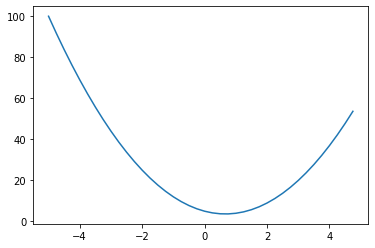

In [53]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [54]:
# Calculate derivative
h = 0.0001
x = -3.0

(f(x + h) - f(x))/h

-21.999700000066014

In [55]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [56]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2  = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)


d1 4.0
d2 4.0002
slope 2.0000000000042206


In [57]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __radd__(self, other): # other + self
        return self + other

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __repr__(self):
        return f"Value(data={self.data})"
    


In [58]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [59]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b; d.label='d'
e = d + c; e.label='e'
f = Value(-2.0, label='f')
L = e * f; L.label='L'
L

Value(data=-8.0)

In [60]:
L._prev, L._op

({Value(data=-2.0), Value(data=4.0)}, '*')

In [61]:
#Visualize expression graph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [62]:
# Manually enter grad values.
L.grad = 1.0
e.grad = -2.0
f.grad = 4.0

d.grad = -2.0
c.grad = -2.0

a.grad = 6.0
b.grad = -4.0

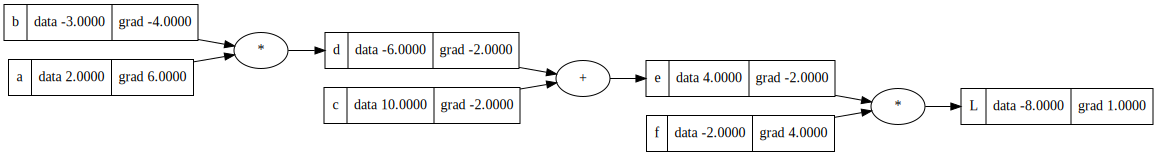

In [63]:
draw_dot(L)

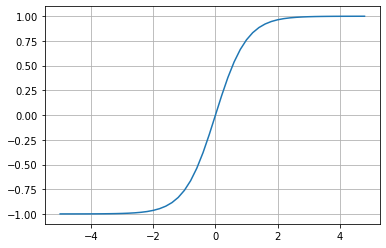

In [64]:
# Activation function - Tanh
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

Biological Neuron<br>
<img src="https://cs231n.github.io/assets/nn1/neuron.png" width="600"><br>
<br>
Mathematical Model<br>
<img src = "https://cs231n.github.io/assets/nn1/neuron_model.jpeg" width="600">

In [65]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'

# o = n.tanh(); o.label='o'
e = (2*n).exp()
o = (e-1) / (e+1)

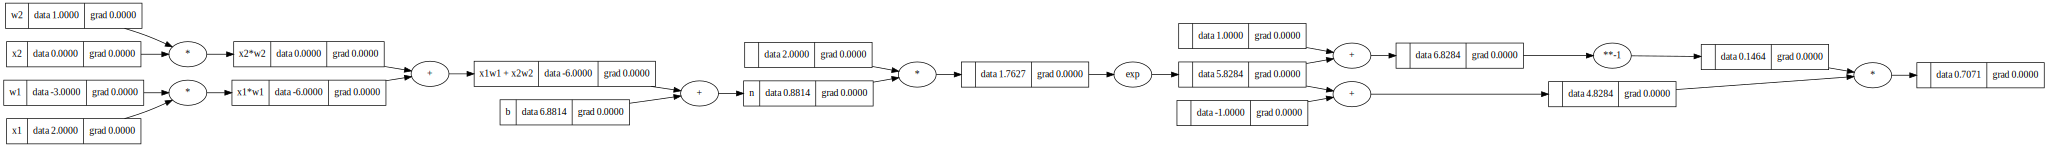

In [66]:
draw_dot(o)

In [67]:
# #Manual Backpropogation through neuron
# o.grad = 1.0

# # o = tanh(n)
# # do/dn = 1 - o**2
# n.grad = 1 - o.data**2

# # Plus operation - local distributer of derivative
# x1w1x2w2.grad = n.grad
# b.grad = n.grad

# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad

# # Mult derviative - y of x & z
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

In [68]:
# o.grad = 1.0
# o._backward()

# n._backward()
# x1w1x2w2._backward()

# x1w1._backward()
# x2w2._backward()

In [69]:
# #Topological sort
# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)

# o.grad = 1.0
# for node in reversed(topo):
#     node._backward()

In [70]:
# #Accumlative gradient
# a = Value(3.0, label='a')
# b = a + a; b.label='b'
# b.backward()
# draw_dot(b)

In [71]:
o.backward()

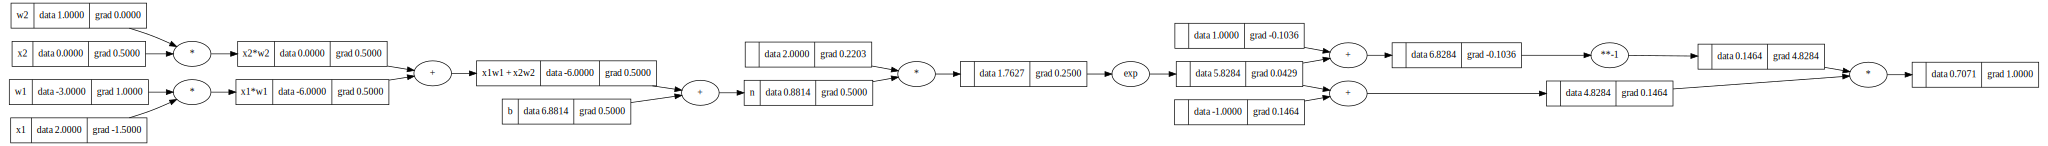

In [72]:
draw_dot(o)

In [73]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        #w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
          

In [74]:
x = [2.0, 3.0, -1.0]

# # Single neuron
# n = Neuron(2)
# n(x)

# # Layer of neurons
# n = Layer(2, 3)
# n(x)

# Multi-Layer Perceptron
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.4422446495580257)

In [75]:
len(n.parameters())

41

In [76]:
n.parameters()

[Value(data=0.3093145900210563),
 Value(data=-0.6258805394135485),
 Value(data=-0.7367064359044229),
 Value(data=0.48552449328724),
 Value(data=-0.4556922021641123),
 Value(data=-0.16133310165703652),
 Value(data=-0.22138391374075295),
 Value(data=-0.060611650527273575),
 Value(data=0.0127477754808214),
 Value(data=0.5874373172744205),
 Value(data=-0.5674665460871267),
 Value(data=-0.9124004593884663),
 Value(data=-0.4213798991228368),
 Value(data=0.5243863359069794),
 Value(data=-0.030143207022442775),
 Value(data=-0.4702899186415421),
 Value(data=0.4266193201778823),
 Value(data=-0.3665007113379104),
 Value(data=-0.9087010203203159),
 Value(data=-0.3655506460412483),
 Value(data=0.7078402194024966),
 Value(data=0.9356633821015898),
 Value(data=0.6144801433892559),
 Value(data=0.2509335523932952),
 Value(data=-0.03260971013354563),
 Value(data=0.08099198241849792),
 Value(data=0.34199141882801887),
 Value(data=0.8705020370664538),
 Value(data=0.6992628137439618),
 Value(data=-0.955630

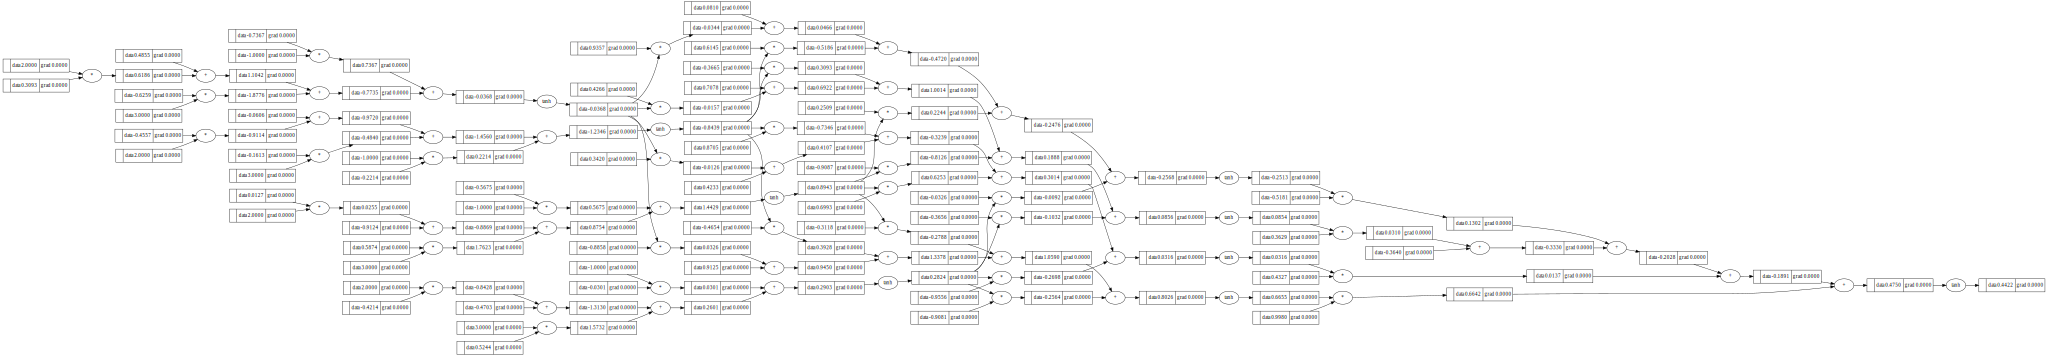

In [77]:
draw_dot(n(x))

In [78]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
    ]

ys = [1.0, -1.0, -1.0, 1.0]

In [79]:
# ypred = [n(x) for x in xs]
# ypred

In [80]:
# #mean-squared error
# loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
# loss

In [81]:
# n.layers[0].neurons[0].w[0].grad
# n.layers[0].neurons[0].w[0].data

In [82]:
for k in range(100):

    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))     #mean-squared error

    #backward pass
    for p in n.parameters(): # zero_grad
        p.grad = 0.0
    loss.backward()

    # update - stocastic gradient descent
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 6.786901154965638
1 3.8014796945443057
2 3.184105803855098
3 2.468927525858382
4 1.0035470555435033
5 0.08174308332426511
6 0.07052699689366593
7 0.06196114271458336
8 0.055196619872181815
9 0.04971812090367647
10 0.04519170000495534
11 0.04139044073805224
12 0.03815439928989127
13 0.035367458071020964
14 0.03294322489741146
15 0.03081607442681055
16 0.028935256789464445
17 0.027260909040052538
18 0.02576128667327436
19 0.024410799836475153
20 0.02318859347220681
21 0.02207750315271359
22 0.021063275430731304
23 0.020133977658189552
24 0.01927954563670734
25 0.018491432956121236
26 0.017762336323605653
27 0.017085978351110177
28 0.016456934260628046
29 0.01587049249450273
30 0.015322541744003913
31 0.01480947874029446
32 0.014328132494010739
33 0.013875701663839468
34 0.013449702478145415
35 0.013047925195104398
36 0.012668397514250493
37 0.012309353680444647
38 0.011969208275025504
39 0.01164653388656565
40 0.01134004200866899
41 0.011048566634595013
42 0.010771050115644127
43 0.010

In [83]:
ypred

[Value(data=0.9755394950731295),
 Value(data=-0.9808305798048264),
 Value(data=-0.9563523610153654),
 Value(data=0.9620890639930009)]

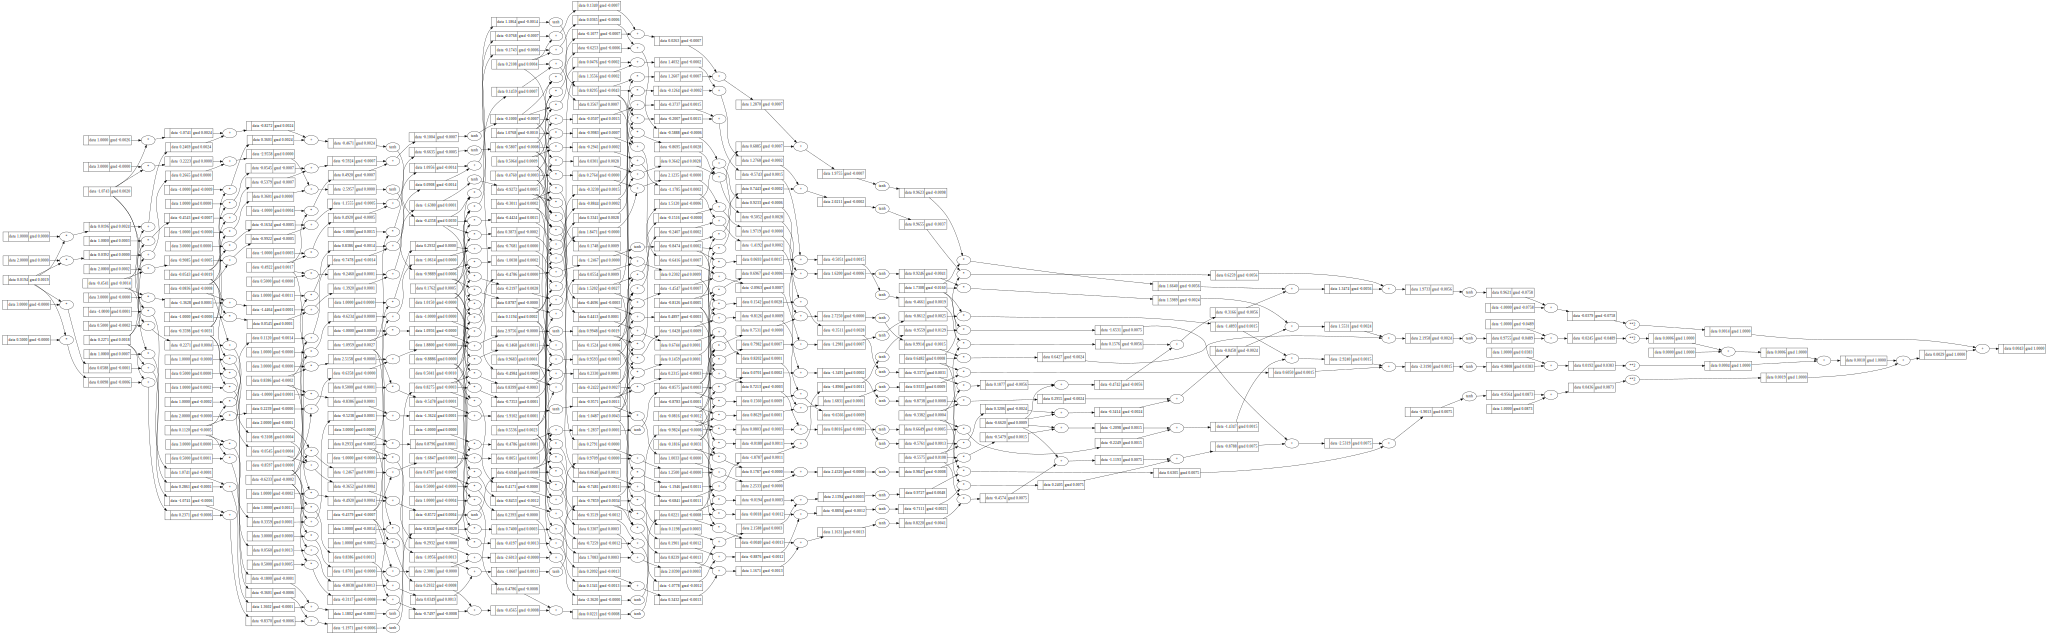

In [84]:
draw_dot(loss)